### Preprocessing 

In [1]:
import os
import xml.etree.ElementTree as ET
import cv2
import easyocr

reader = easyocr.Reader(['en'])

def parse_annotation(xml_file):
    """
    Parse the XML file to get the bounding box coordinates and the filename of the associated image.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.iter('object'):
        xmlbox = obj.find('bndbox')
        x_min = int(xmlbox.find('xmin').text)
        y_min = int(xmlbox.find('ymin').text)
        x_max = int(xmlbox.find('xmax').text)
        y_max = int(xmlbox.find('ymax').text)
        return filename, (x_min, y_min, x_max, y_max)

def crop_and_resize_image(image_path, bbox, target_size=(224, 224)):
    """
    Crop the image to the bounding box and resize it to the target size.
    """
    image = cv2.imread(image_path)
    cropped_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    resized_image = cv2.resize(cropped_image, target_size)
    return resized_image

def preprocess_dataset(annotations_path, images_path, output_path, target_size=(224, 224)):
    """
    Process all images in the dataset, cropping to the bounding box and resizing to the target size.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    for xml_file in os.listdir(annotations_path):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_path, xml_file)
            filename, bbox = parse_annotation(xml_path)
            image_path = os.path.join(images_path, filename)
            processed_image = crop_and_resize_image(image_path, bbox, target_size)
            
            # Save the processed image
            output_file_path = os.path.join(output_path, filename)
            cv2.imwrite(output_file_path, processed_image)

# Paths to your dataset
annotations_path = 'archive/annotations'
images_path = 'archive/images'
output_path = 'archive/processed_images'

# Preprocess the dataset
preprocess_dataset(annotations_path, images_path, output_path)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [17]:
import easyocr
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize the easyocr reader with English
reader = easyocr.Reader(['en'])

image_directory = 'archive/processed_images'
img_height, img_width = 224, 224  # Should match your preprocessing size
batch_size = 32

def load_images(image_directory, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(image_directory):
        if filename.endswith('.png'):
            img_path = os.path.join(image_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            images.append(img)

            # Use OCR to read text from image, character by character
            results = reader.readtext(img, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ', detail=0)
            
            # Concatenate detected characters to form the label
            label = ''.join(results)
            labels.append(label)

    return np.array(images), np.array(labels)

# Assuming 'image_directory' is defined and points to your processed images
images, labels = load_images(image_directory, (img_height, img_width))


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [18]:
print(labels[:433])

['WUU' 'DID2' 'HW' 'KA' '' 'I' 'H7GHGSH' 'I' 'IHWVM' '07MMNTOYOHA' 'HHR'
 'IPHAI6' 'MENE60Y' 'HHI' 'GUUL' 'B69VSL' 'M20E1P0' 'HHH' 'DHUK' 'HV'
 'AND10YE5' 'IMGTUAMAUU' '9UJ' 'WY' 'COSTARUA0052QENROANERIA' 'W' 'HHMVH'
 'I' 'KLASHAQHU' 'HHRMWWW' 'WADOCI' 'II' 'BYOHD' 'MIWW' 'IIHM' 'BESPUBI'
 'YUSYAXSU' 'MM' 'M' 'JHAUHL' 'HH' 'HH' 'LLULDI' 'JU' 'HL' 'IY' 'MBIL'
 '00' 'IM' '0S7RM' 'EI' 'IMRGIUHYAUSA' 'WH' 'HADOIUB' 'WYYYOH' 'LOFTOTL'
 'VES00SS' 'HINGROOTKT9' 'HHM' 'NOTAGOPL' 'F05022DUBALLVJ' 'WH' 'WW'
 'HRWHH' 'H' 'KWID' 'IHTZVN' '9214' '' 'HWH' 'M' 'HM' 'W' 'VH'
 'IGTAEWASHNGTONIPEHCHH' 'IH' '05A4' 'M' 'EABO0OI' 'SUM' 'HH'
 '1268UNUIWNOAIQ' 'IDX3' 'KA105H616' 'NEVAD8O0L'
 'ILUM00121OCVU8FVOPFTHROADITIRACE044TC00' 'JHH34941' 'GHOAHUO'
 'PHNSLT837U' 'VMUZIUHV232' 'IHR' '' 'HMH' '' 'KWID' 'UOPECLOLVIRGIMIA'
 'KLB055' 'HVHNHU6' 'HCIIL' 'JWHLHMH' 'IAJI' 'MMIMMNM' 'RON9' 'HB4887'
 'HVIRGINIAVWWHUP' 'BYH' '' 'BHH' 'MLUNMMMIU' 'WMLMR' 'HMVIPERGOUMUMNL'
 'BVHN436' 'WWJ' 'WM' '101626J' 'MEYIH' 'HOY

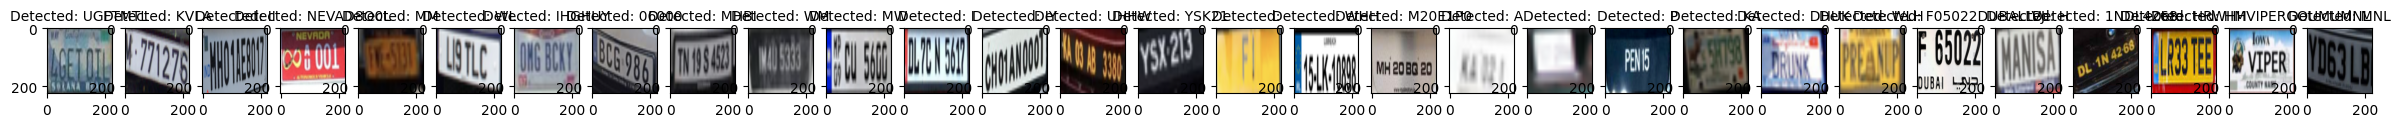

In [27]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Example of displaying the plates with detected text
plt.figure(figsize=(30,10))
for i, img in enumerate(X_train[:30]):  # Display first 5 images and their OCR results
    plt.subplot(1, 30, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected: {y_train[i]}', fontdict={'fontsize': 10})
plt.show()

In [3]:
from easyocr import Reader  # Assuming you are using EasyOCR for text detection
reader = Reader(['en'])  # Initialize the reader, specify the language as needed
import numpy as np

def load_images(image_directory, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(image_directory):
        if filename.endswith('.png'):
            img_path = os.path.join(image_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            images.append(img)

            # Use OCR to read text from image
            results = reader.readtext(img)
            # You might want to refine how you extract the label from the results
            # Here we take the text with the highest confidence if there are multiple detections
            if results:
                # Sort results by confidence and take the text of the highest confidence result
                label = max(results, key=lambda result: result[2])[1]
                labels.append(label)
            else:
                labels.append('')  # or some placeholder text if no text detected

    return np.array(images), np.array(labels)




Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [4]:
image_directory = 'archive/processed_images'
img_height, img_width = 224, 224  # Should match your preprocessing size
batch_size = 32

images, labels = load_images(image_directory, (img_height, img_width))

['Wbh' '2' 'Hw' 'KA' '']


In [16]:
print(labels[:433])
# print(images[:5])

['Wbh' '2' 'Hw' 'KA' '' 'Ihhh' 'H7G HG SH' 'I' 'IHwV M' 'MMN' 'HHR'
 'IPlAI6' 'MENE' 'WbaM' 'GUUL' 'Be9 Vsc|' 'M20p1 P0' 'HHH' 'DHuK' 'HV'
 'AND' 'GT' '9' 'WY' '0052' 'W' 'M' 'I' 'KLASHAQHU' 'HHRMWWW' 'Wa' 'I'
 'BYOHD' 'M' 'I' 'BES' 'YUSYAXSU ' 'M' 'M' 'JHAUHL' 'HH' 'HH' 'LLULDI]'
 'JU' 'HL' 'IY' 'M' '00' 'IhM' '0S7 RM' 'EI' "'MRGIU" 'WH' 'Ha' 'W'
 'LOFTOTL' 'VES' 'HINGROOT ' 'HHM' 'NTacOp]' 'F 05022' 'WH' 'Ww' 'HrwHH'
 'H' 'KWID' 'INTZUNG |' '9214' '' 'HWH' 'M' 'V' 'W' 'VH' 'WaSHNGTON' 'Hu'
 '05 A4' 'M' 'Eab' 'SUM' 'HH' "1268'" 'IDX3' 'KA' "'Nevadn'" 'ROADITIRACE'
 'JHh 34941' 'GHOAH_bo' 'LT837U' 'V232' 'IHR' '' 'HMh' '' 'KWID'
 'OPEC LOL' 'KL' 'HVHN Hu6' 'HCItL' 'JWHLHMH' 'Jlln;' 'MMIM' 'RON $' '887'
 'WHUP' 'ByH' '' 'BHH' 'NMM' 'WML MR' 'VIPER' 'BVHN /36' 'W' 'WlM'
 '1v1G26' 'MEYIH' 'HOYU' '42.68 ' 'MH popg p0' 'FXML:324' 'AFR 20' 'VHW'
 "'5957" '20' 'AVMbim ' 'MHH' 'HZS HG SIM' 'HY' 'SHHHbH' 'M' 'HY' ''
 'UGFTMTL' 'HOHLZ' 'M U' 'IhI' 'IWEW' 'WLH' 'Mh popd 20' 'WASHNGTON'
 'AFR 20' 

In [7]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [2]:
# import tensorflow as tf
# # from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split
# import numpy as np
# import cv2
# import os

# # Parameters
# image_directory = 'archive/processed_images'
# img_height, img_width = 224, 224  # Should match your preprocessing size
# batch_size = 32

# # Load and preprocess images
# def load_images(image_directory, target_size=(224, 224)):
#     images = []
#     labels = []  # Assuming labels can be derived from file names or another source

#     for filename in os.listdir(image_directory):
#         if filename.endswith('.png'):
#             img_path = os.path.join(image_directory, filename)
#             img = cv2.imread(img_path)
#             img = cv2.resize(img, target_size)
#             images.append(img)
#             # Extract label from filename or another source
#             label = reader.readtext(img)
#             # label = filename.split('_')[0]  # Modify as per your naming convention
#             labels.append(label)

#     return np.array(images), np.array(labels)

# images, labels = load_images(image_directory, (img_height, img_width))

# # Split the dataset


2024-04-07 22:24:15.515644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (433,) + inhomogeneous part.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')  # Assuming a classification task
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [9]:
# You may need to convert labels to numeric if they are not already
# This is a simplistic example; in practice, you would use label encoding or one-hot encoding

# Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=batch_size)


Epoch 1/10


2024-04-07 22:43:19.899808: W tensorflow/core/framework/op_kernel.cc:1807] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node 'Cast_25' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/kreenatotala/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/sg/4lgvyv552gxd10hdnmvjlmjr0000gn/T/ipykernel_2053/3033655264.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=batch_size)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1055, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 676, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_25'
Cast string to float is not supported
	 [[{{node Cast_25}}]] [Op:__inference_train_function_1290]